In [108]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import PIL.Image

import tensorflow as tf

In [151]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'
url = 'https://upload.wikimedia.org/wikipedia/commons/3/35/Neckertal_20150527-6384.jpg'
url = 'https://media-exp3.licdn.com/dms/image/C4D1BAQFsdjpzrtQWUA/company-background_10000/0/1519796755846?e=2159024400&v=beta&t=tL2HSXGgliQAAqXK0ZvfDvXvdRD2j3Gpk_juoBRmYlM'

In [152]:
def download(url, max_dim = None):
    name = url.split("/")[-1]
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = tf.keras.preprocessing.image.load_img(image_path,target_size = (800,1200))
    img = tf.keras.preprocessing.image.img_to_array(img)
    return img

In [153]:
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

In [154]:
def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))

786432/785372 [==============================] - 0s 0us/step


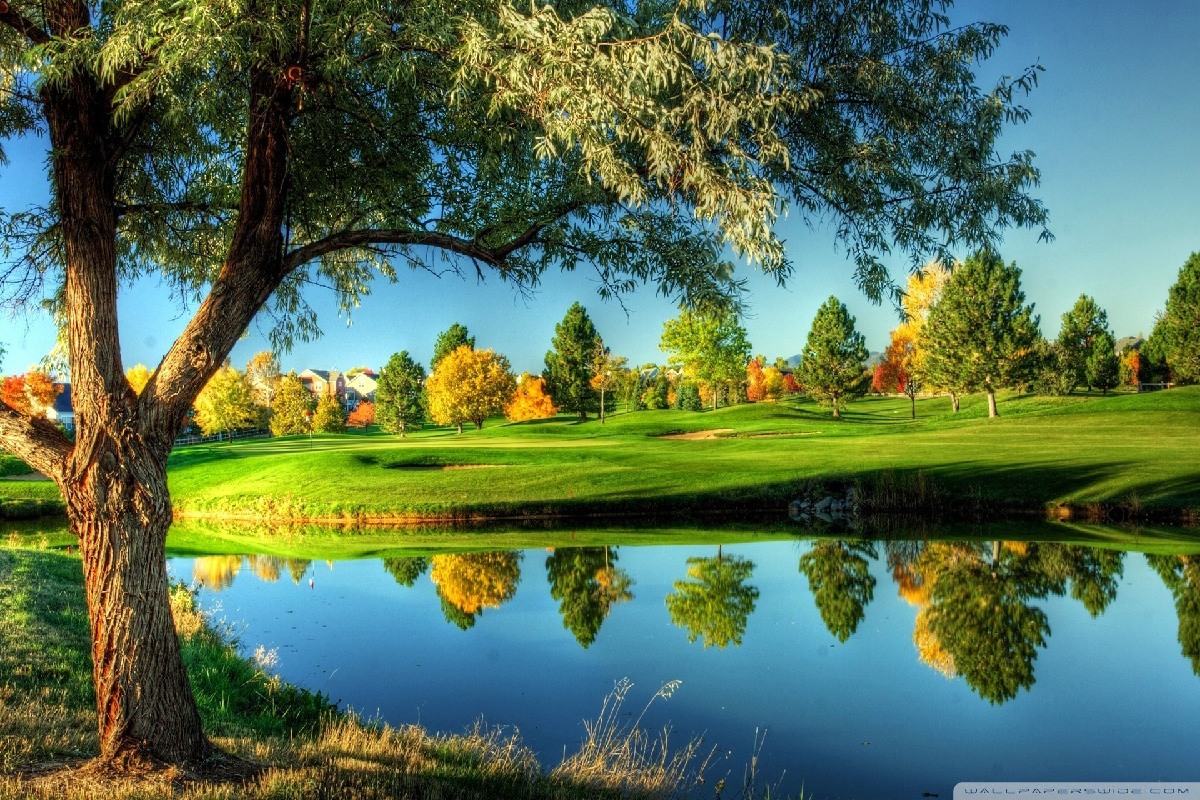

In [155]:
original_img = download(url, max_dim = 1000)
# original_img = tf.keras.preprocessing.image.load_img('/content/wp4741055.jpg',target_size = (1000,1600))
# original_img = tf.keras.preprocessing.image.img_to_array(original_img)
show(original_img.astype('uint8'))

In [140]:
base_model = tf.keras.applications.InceptionV3(include_top = False, weights = 'imagenet')

In [141]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_470 (Conv2D)             (None, None, None, 3 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_470 (BatchN (None, None, None, 3 96          conv2d_470[0][0]                 
__________________________________________________________________________________________________
activation_470 (Activation)     (None, None, None, 3 0           batch_normalization_470[0][0]    
_______________________________________________________________________________________

In [165]:
names = ["mixed7", "mixed9"]
dream_models = [tf.keras.Model(inputs = base_model.input, outputs = base_model.get_layer(name).output) for name in names]

In [166]:
def calc_loss(img, dream_models):
    img = tf.expand_dims(img, axis = 0)
    losses = []
    for model in dream_models:
        losses.append(tf.math.reduce_mean(model(img)))
        
    return tf.reduce_mean(losses)

In [167]:
class DeepDream(tf.Module):
    def __init__(self, models):
        self.models = models
    
    @tf.function(
        input_signature = (
            tf.TensorSpec(shape = [None, None, 3], dtype = tf.float32),
            tf.TensorSpec(shape = [], dtype = tf.int32),
            tf.TensorSpec(shape = [], dtype = tf.float32),)
        
    )
    
    def __call__(self, img, steps, step_size):
        print('Tracing')
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape(persistent = True) as tape:
                # This needs gradients relative to `img`
                # `GradientTape` only watches `tf.Variable`s by default
                tape.watch(img)
                loss = calc_loss(img, self.models)
                
            # Calculate the gradient of the loss with respect to the pixels of the input image.
            gradients = tape.gradient(loss, img)
            
            #Normalize the gradients.
            gradients /= tf.math.reduce_std(gradients) + 1e-8
            
            # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
            # You can update the image by directly adding the gradients (because they're the same shape!)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)
            
        return loss, img

In [168]:
deepDream = DeepDream(dream_models)

In [169]:
def run_deep_dream(img, steps = 100, step_size = 0.01):
    #Convert from uint8 to the range expected by the model.
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    while steps_remaining:
        if steps_remaining > 100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -= run_steps
        step += run_steps
        
        loss, img = deepDream(img, run_steps, tf.constant(step_size))
        
        display.clear_output(wait = True)
        show(deprocess(img))
        print("Step {0}, loss {1}".format(step, loss))
    
    result = deprocess(img)
    display.clear_output(wait = True)
    return result

In [170]:
# dream_img = run_deep_dream(img = original_img, steps = 100, step_size = 0.01)

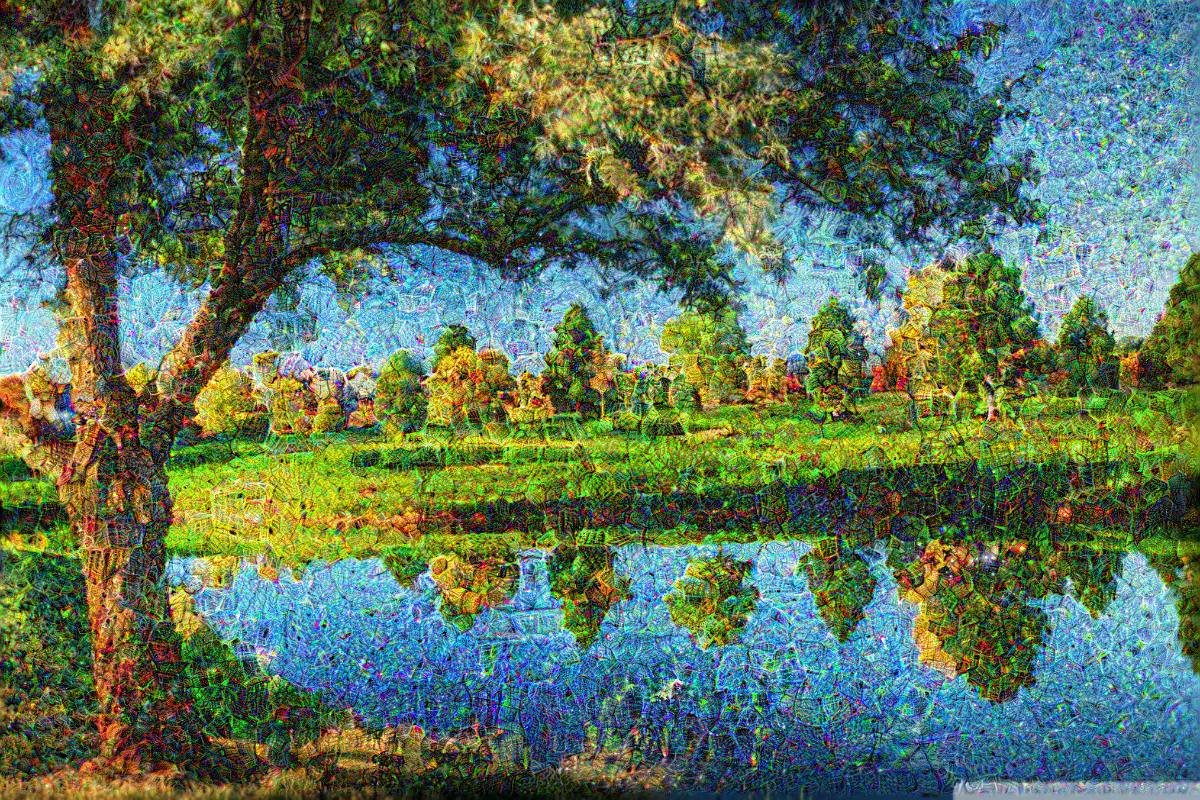

691.9964511394501

In [173]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
    new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

    img = tf.image.resize(img, new_shape).numpy()

    img = run_deep_dream(img=img, steps=500, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start